# 해당 코드는 DACON Baseline코드를 사용하였습니다.

In [1]:
# 필요 패키지 로드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
%matplotlib inline
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols 
from statsmodels.api import OLS, add_constant

In [2]:
Basic_dir = os.path.dirname(os.path.dirname(os.path.realpath('EDA.ipynb')))
PATH = Basic_dir + '\\Data\\Data(WineQ_B)\\'
os.listdir(PATH)

['sample_submission(DT01).csv',
 'sample_submission(DT02).csv',
 'sample_submission(KNN01).csv',
 'sample_submission(KNN02).csv',
 'sample_submission(NT01).csv',
 'sample_submission(NT02).csv',
 'sample_submission(로지스틱 회귀).csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [3]:
# 데이터 로드
train = pd.read_csv(PATH + '\\train.csv')
test = pd.read_csv(PATH + '\\test.csv')
print(train.columns)
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)
# 범주형 변수 인코딩 : 와인 종류 - 0 : 화이트, 1: 레드
train.type = np.where(train.type == 'white', 0, 1)
test.type = np.where(test.type == 'white', 0, 1)

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type',
       'quality'],
      dtype='object')


In [4]:
# 순위변수(품질)와 연속형변수(x_list에 해당하는 자료들)을 분석하기 위해 스피어만 상관계수 사용
# 품질을 연속형으로 보면 회귀 및 피어슨 상관계수분석 가능
# p-value가 0.05 이하인 변수들은 제외
from scipy import stats
x_list = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
          'pH', 'sulphates', 'alcohol']
val_list = []
for col in x_list:
    if stats.spearmanr(train[col], train.quality)[1] < 0.05:
        val_list.append(col)
        print(f'{col} : {round(stats.spearmanr(train[col], train.quality)[0], 3)}, {round(stats.spearmanr(train[col], train.quality)[1], 5)}')
val_list = val_list + ['type']
# 변형 - 낮은 상관계수를 가진 변수들 제거
val_list.remove('citric acid')
val_list.remove('free sulfur dioxide')
val_list.remove('total sulfur dioxide')
val_list.remove('pH')
print(val_list)

fixed acidity : -0.109, 0.0
volatile acidity : -0.254, 0.0
citric acid : 0.08, 1e-05
chlorides : -0.286, 0.0
free sulfur dioxide : 0.082, 0.0
total sulfur dioxide : -0.058, 0.00092
density : -0.329, 0.0
pH : 0.044, 0.01194
alcohol : 0.449, 0.0
['fixed acidity', 'volatile acidity', 'chlorides', 'density', 'alcohol', 'type']


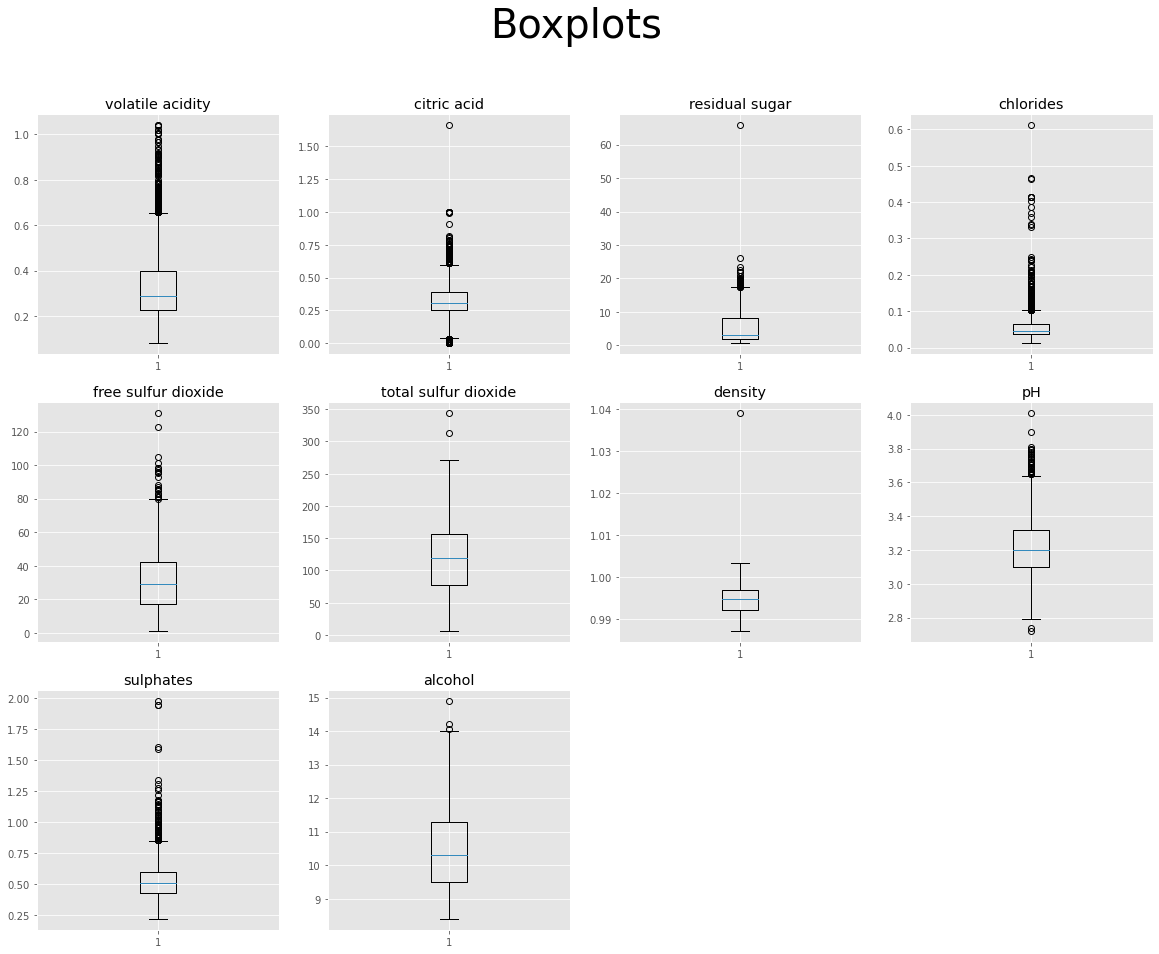

In [5]:
plt.style.use("ggplot")

# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,15))
plt.suptitle("Boxplots", fontsize=40)

# id, type, quality는 제외하고 시각화합니다.
cols = train.columns[1:-2]
for i in range(len(cols)):
    plt.subplot(3,4,i+1)
    plt.title(cols[i])
    plt.boxplot(train[cols[i]])
plt.show()

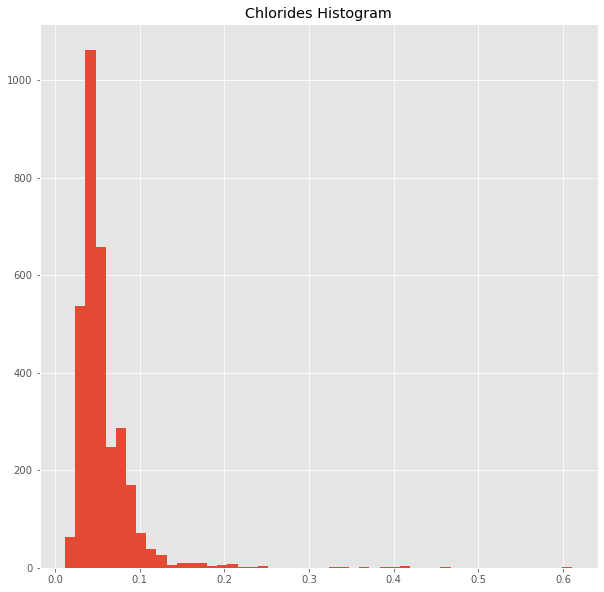

In [6]:
# Boxplot을 봤을 때 가장 이상치가 많았던 chlorides 를 살펴봅시다.
plt.figure(figsize=(10,10))
plt.hist(train['chlorides'], bins=50)
plt.title('Chlorides Histogram')
plt.show()

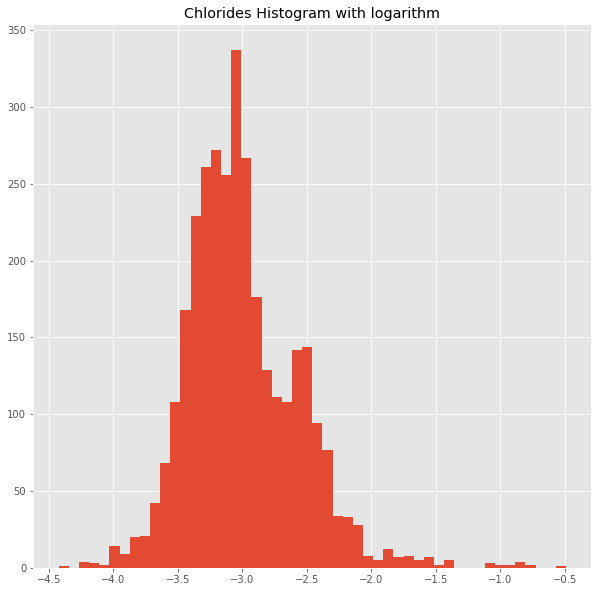

In [7]:
log_chlorides = np.log(train['chlorides'])

plt.figure(figsize=(10,10))
plt.hist(log_chlorides, bins=50)
plt.title('Chlorides Histogram with logarithm')
plt.show()

In [8]:
def logarithm_scaler(df):
    # log a 는 a>0 인 경우에 성립하므로 min 값이 0 인 column은 루트 변환을 적용합니다.
    epsilon = 1e-10
    for i in df.columns:
        if df[i].min() == 0:
            df[i] = np.sqrt(df[i])
        else:
            df[i] = np.log(df[i])
    return df

# log 변환이 필요없는 feature는 제외합니다.
transform_data1 = train.drop(columns=['type', 'total sulfur dioxide', 'quality']) 
transform_data2 = test.drop(columns=['type', 'total sulfur dioxide']) 

train[transform_data1.columns] = logarithm_scaler(transform_data1)
test[transform_data2.columns] = logarithm_scaler(transform_data2)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,2.079442,-1.714798,0.608276,0.262364,-3.218876,2.708050,96.0,-0.008839,1.118415,-0.494296,2.493205,0,6
1,2.014903,-0.967584,0.538516,1.589235,-3.863233,3.637586,113.0,-0.009788,1.124930,-0.733969,2.564949,0,7
2,1.808289,-1.309333,0.574456,0.788457,-3.863233,3.258097,117.0,-0.011465,1.137833,-1.203973,2.525729,0,6
3,1.856298,-1.139434,0.707107,2.370244,-3.057608,4.043051,206.0,-0.003205,1.124930,-0.510826,2.240710,0,5
4,2.128232,-0.994252,0.655744,0.832909,-2.764621,2.484907,19.0,-0.004510,1.153732,-0.210721,2.415914,1,7


In [9]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1.987874,-1.171183,0.500000,1.894617,-3.442019,3.401197,138.0,-0.007589,1.064711,-0.994252,2.406945,0
1,2.163323,-0.356675,0.489898,0.916291,-1.487220,1.609438,15.0,-0.000900,1.199965,-0.510826,2.197225,1
2,1.931521,-0.462035,0.100000,0.875469,-2.577022,2.639057,39.0,-0.004791,1.205971,-0.634878,2.379546,1
3,1.840550,-1.469676,0.707107,2.341806,-3.146555,4.110874,132.0,-0.004591,1.050822,-0.776529,2.208274,0
4,1.931521,-0.616186,0.200000,1.098612,-2.563950,1.945910,27.0,-0.001301,1.305626,-0.094311,2.240710,1


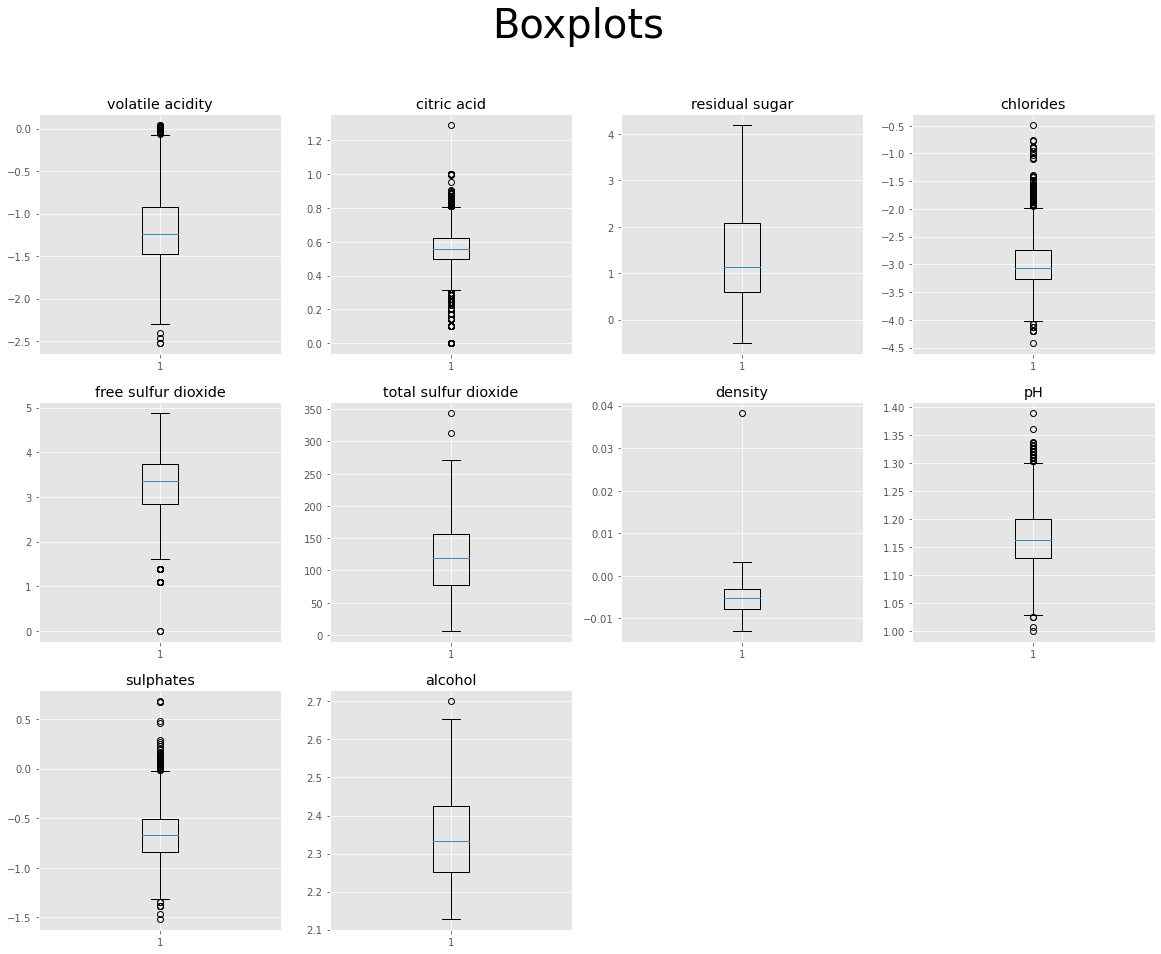

In [10]:
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,15))
plt.suptitle("Boxplots", fontsize=40)
cols = train.columns[1:-2]
for i in range(len(cols)):
    plt.subplot(3,4,i+1)
    plt.title(cols[i])
    plt.boxplot(train[cols[i]])
plt.show()

In [11]:
transform_data1 = train.drop(columns=['type', 'quality']) 
transform_data2 = test.drop(columns=['type']) 

# 가장 일반적인 Standard Scaler를 사용합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

std_transform_data1 = scaler.fit_transform(transform_data1)
std_transform_data2 = scaler.fit_transform(transform_data2)

train[transform_data1.columns] = std_transform_data1
test[transform_data2.columns] = std_transform_data2

train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,0.725564,-1.209520,0.420652,-1.220969,-0.521026,-0.742326,-0.363344,-1.137561,-0.957315,0.671074,1.332218,0,6
1,0.331005,0.508800,-0.040030,0.305077,-2.015390,0.601149,-0.058413,-1.447071,-0.827105,-0.263347,1.976322,0,7
2,-0.932141,-0.277099,0.197310,-0.615905,-2.015390,0.052666,0.013335,-1.994371,-0.569203,-2.095767,1.624205,0,6
3,-0.638634,0.113607,1.073311,1.203323,-0.147021,1.187176,1.609735,0.700270,-0.827105,0.606631,-0.934641,0,5
4,1.023845,0.447473,0.734119,-0.564780,0.532462,-1.064840,-1.744499,0.274552,-0.251436,1.776659,0.638308,1,7


In [12]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0.154583,0.008212,-0.270504,0.660311,-1.061068,0.269240,0.403475,-0.775395,-2.124330,-1.271218,0.568075,0
1,1.222912,1.857632,-0.335467,-0.480735,3.507027,-2.295131,-1.770665,1.487553,0.633427,0.604571,-1.319425,1
2,-0.188557,1.618401,-2.842767,-0.528346,0.960311,-0.821537,-1.346442,0.171040,0.755886,0.123223,0.321482,1
3,-0.742496,-0.669546,1.061328,1.181878,-0.370609,1.284930,0.297419,0.239027,-2.407521,-0.426409,-1.219975,0
4,-0.188557,1.268386,-2.199701,-0.268089,0.990859,-1.813571,-1.558554,1.352066,2.787811,2.220729,-0.928056,1


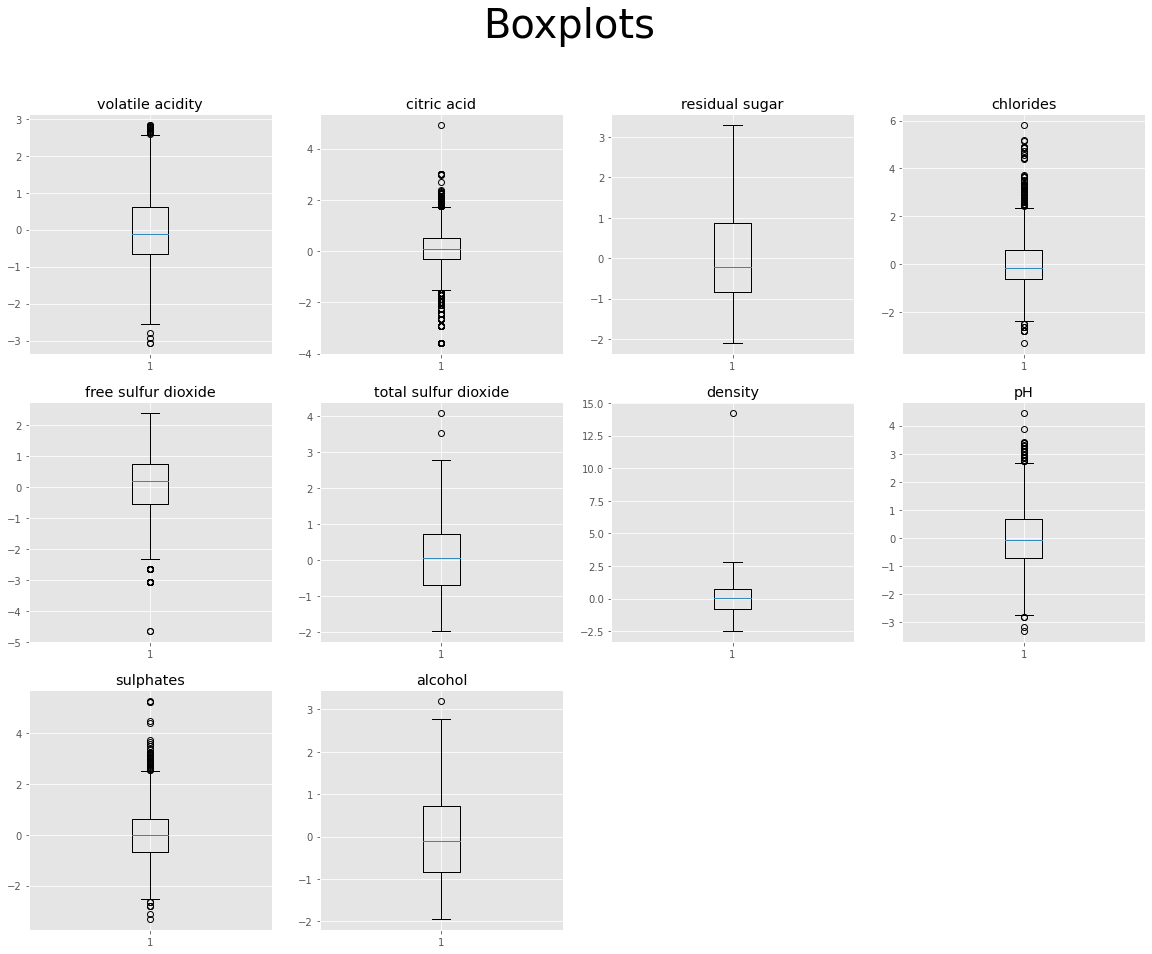

In [13]:
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,15))
plt.suptitle("Boxplots", fontsize=40)
cols = train.columns[1:-2]
for i in range(len(cols)):
    plt.subplot(3,4,i+1)
    plt.title(cols[i])
    plt.boxplot(train[cols[i]])
plt.show()

In [14]:
# 이상치를 제거합니다.(test데이터는 제거하면 안됩니다.)
before_remove = len(train)
train[transform_data1.columns] = np.where(abs(std_transform_data1) > 3, np.nan, std_transform_data1)
train = train.dropna()
print('Removed : -', before_remove - len(train))

Removed : - 207


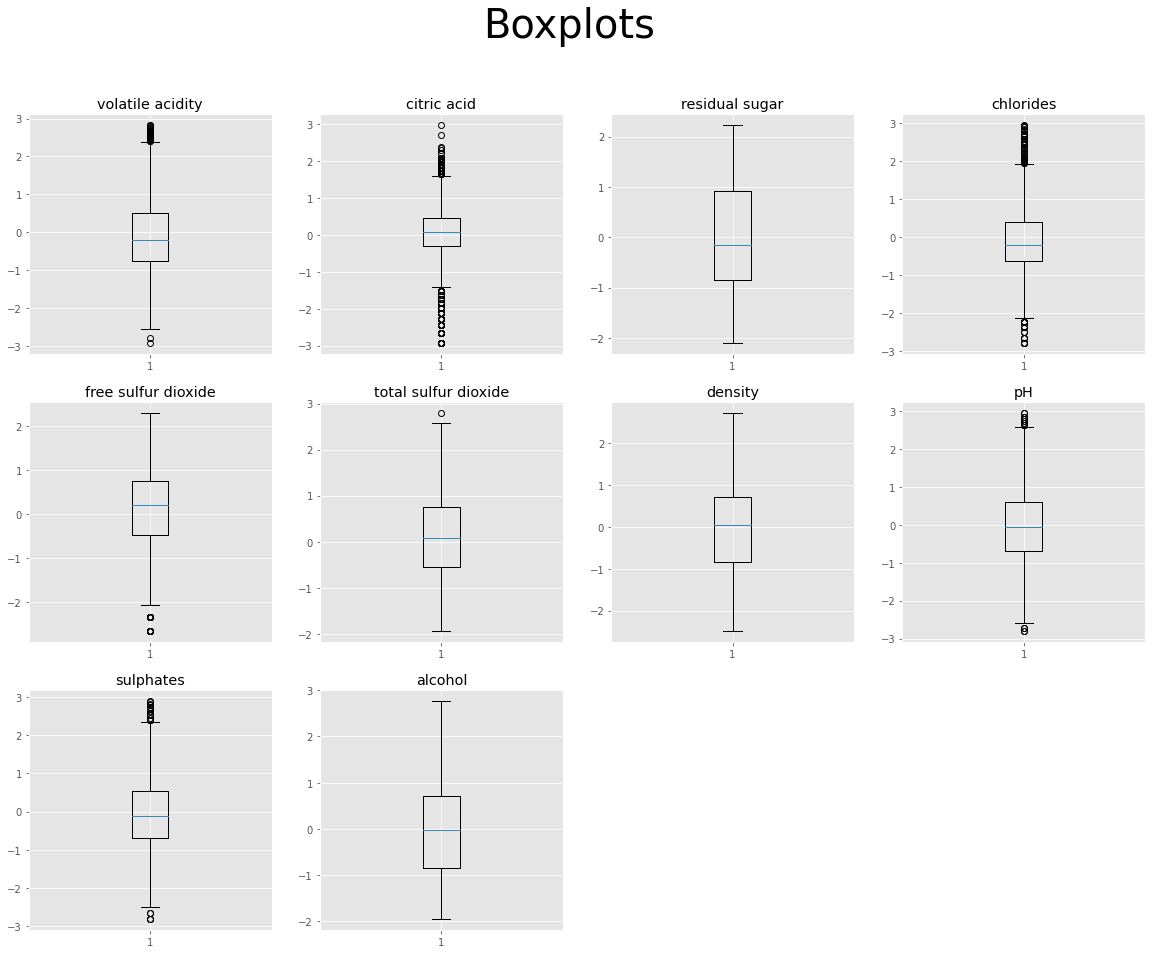

In [15]:
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,15))
plt.suptitle("Boxplots", fontsize=40)
cols = train.columns[1:-2]
for i in range(len(cols)):
    plt.subplot(3,4,i+1)
    plt.title(cols[i])
    plt.boxplot(train[cols[i]])
plt.show()

In [16]:
# 클래스 불균형 처리를 해주는 imbalanced-learn를 호출
# 오버 샘플링 시행
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler()
ov_data, ov_label = ros.fit_resample(train[val_list].copy(), train[['quality']].copy())
ov_data = pd.DataFrame(ov_data, columns = val_list)
ov_data['quality'] = ov_label
len(train), len(ov_data)

(3024, 6615)

In [17]:
ov_data.quality.value_counts()

6    1323
7    1323
5    1323
8    1323
4    1323
Name: quality, dtype: int64

In [19]:
ov_data.head()

,fixed acidity,volatile acidity,chlorides,density,alcohol,type,quality
0,0.725564,-1.209520,-0.521026,-1.137561,1.332218,0,6
1,0.331005,0.508800,-2.015390,-1.447071,1.976322,0,7
2,-0.932141,-0.277099,-2.015390,-1.994371,1.624205,0,6
3,-0.638634,0.113607,-0.147021,0.700270,-0.934641,0,5
4,1.023845,0.447473,0.532462,0.274552,0.638308,1,7


In [32]:
test[val_list].head()

,fixed acidity,volatile acidity,chlorides,density,alcohol,type
0,0.154583,0.008212,-1.061068,-0.775395,0.568075,0
1,1.222912,1.857632,3.507027,1.487553,-1.319425,1
2,-0.188557,1.618401,0.960311,0.171040,0.321482,1
3,-0.742496,-0.669546,-0.370609,0.239027,-1.219975,0
4,-0.188557,1.268386,0.990859,1.352066,-0.928056,1


In [21]:
# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], \
                                test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [23]:
# KNN 모델
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
# 정확도 테스트(훈련데이터 셋)
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(X_train, list(y_train.quality))
y_pred = neigh_n.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(classification_report(y_train, y_pred))
print(f'Accuracy : {accuracy*100}')

              precision    recall  f1-score   support

           4       1.00      1.00      1.00      1191
           5       1.00      1.00      1.00      1190
           6       1.00      1.00      1.00      1191
           7       1.00      1.00      1.00      1191
           8       1.00      1.00      1.00      1190

    accuracy                           1.00      5953
   macro avg       1.00      1.00      1.00      5953
weighted avg       1.00      1.00      1.00      5953

Accuracy : 99.98320174701831


In [24]:
# 정확도 테스트(테스트데이터 셋)
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(X_train, list(y_train.quality))
y_pred = neigh_n.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy*100}')

              precision    recall  f1-score   support

           4       0.86      1.00      0.92       132
           5       0.75      0.77      0.76       133
           6       0.80      0.36      0.49       132
           7       0.78      0.98      0.87       132
           8       0.92      1.00      0.96       133

    accuracy                           0.82       662
   macro avg       0.82      0.82      0.80       662
weighted avg       0.82      0.82      0.80       662

Accuracy : 82.17522658610272


In [41]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = neigh_n.predict(test[val_list])
predict.to_csv(PATH + 'sample_submission(KNN03).csv', index = False)
pd.read_csv(PATH + 'sample_submission(KNN03).csv').head()

,id,quality
0,1,6
1,2,5
2,3,5
3,4,5
4,5,6


# ------------------------------------------------------------------------------

In [63]:
# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], \
                                test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [64]:
# 학습데이터로 사용하기 위해 pandas파일을 numpy파일로 변환
print(X_train.shape, X_train.to_numpy().shape, X_test.shape, X_test.to_numpy().shape)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.quality.to_numpy()
y_test = y_test.quality.to_numpy()

(5953, 6) (5953, 6) (662, 6) (662, 6)


In [65]:
# 신경망 분류모델 작성
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# quality가 범주형이므로 범주형으로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, y_train.shape) 

(5953, 6) (5953, 9)


In [ ]:
# 입력데이터의 형태를 반드시 입력해주어야 함
# 차원이 6개 -> input값 일치화
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (6, ))) # 6차원의 데이터를 입력으로 받고, 64개의 출력 가지는 첫번째 Dense층
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 가지는 Dense층
model.add(Dense(9, activation = 'softmax')) # 9개의 출력을 가지는 신경망(마지막은 반드시 y의 변수 종류수와 일치시켜줄 것)

# 학습과정 설정하기
# 옵티마이저 : Adam, 손실함수 : categorical_crossentropy, 모니터링할 평가지표 : acc
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()
# 모델학습하기
history = model.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_data = (X_test, y_test))

In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

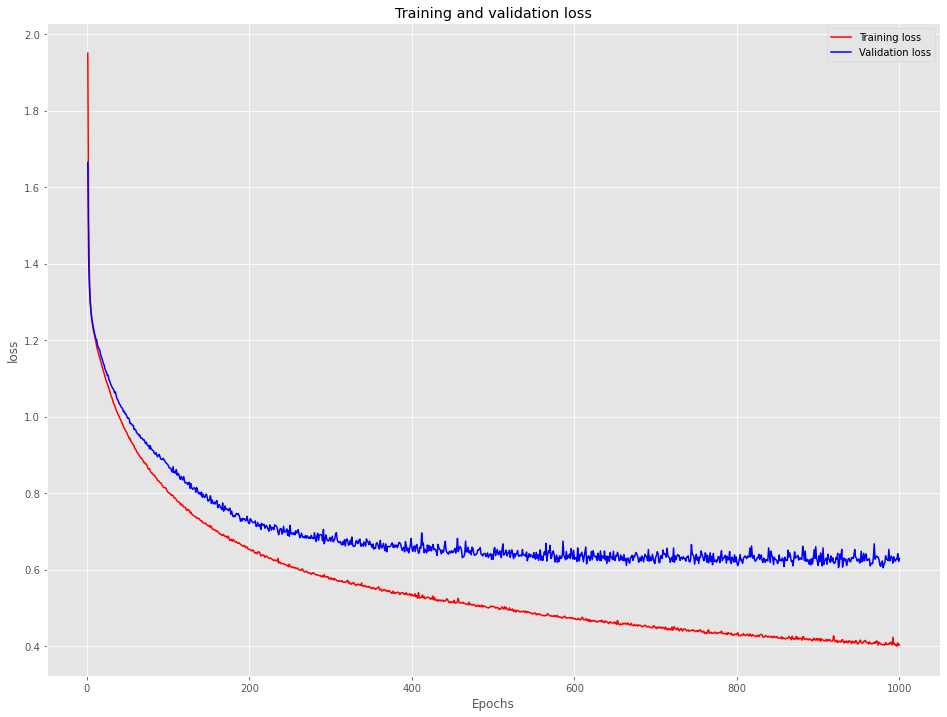

In [68]:
import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)
plt.figure(figsize = (16, 12))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

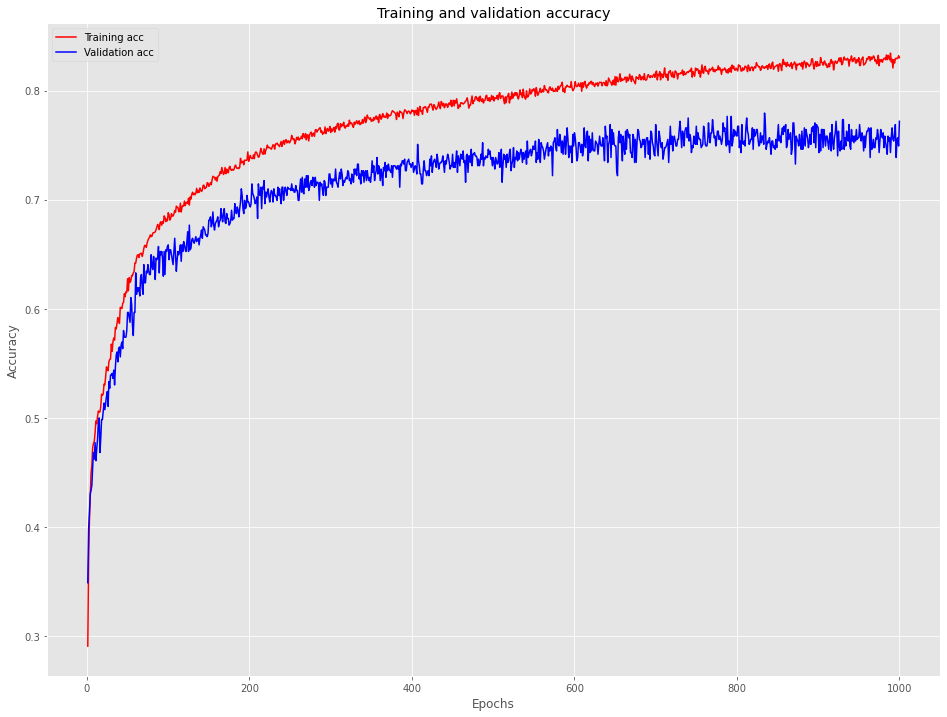

In [69]:
plt.clf()
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']

plt.figure(figsize = (16, 12))
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
# 학습한 모델 평가
model.evaluate(X_test, y_test) # loss, accuracy

21/21 [==============================] - 0s 570us/step - loss: 0.6292 - categorical_accuracy: 0.7719


[0.6291679739952087, 0.7719033360481262]

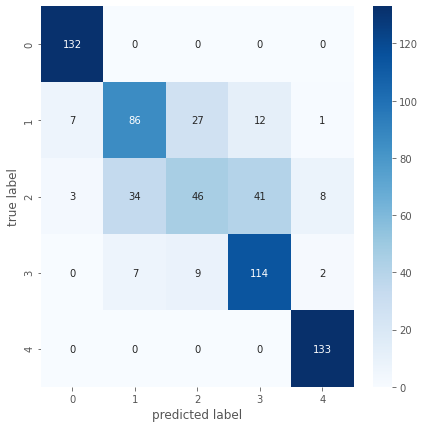

In [71]:
# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results = model.predict(X_test)
plt.figure(figsize = (7, 7))
cm = confusion_matrix(np.argmax(y_test, axis = -1), np.argmax(results, axis = -1))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [72]:
print(classification_report(np.argmax(y_test, axis = -1), np.argmax(results, axis = -1)))

              precision    recall  f1-score   support

           4       0.93      1.00      0.96       132
           5       0.68      0.65      0.66       133
           6       0.56      0.35      0.43       132
           7       0.68      0.86      0.76       132
           8       0.92      1.00      0.96       133

    accuracy                           0.77       662
   macro avg       0.75      0.77      0.76       662
weighted avg       0.75      0.77      0.76       662



In [73]:
# 학습한 모델로 예측하기
import numpy as np
df_test01 = test[val_list].copy()
df_test01.iloc[:, :5] = scaler.fit_transform(df_test01.iloc[:, :5])
df_test01 = df_test01.to_numpy()
print(df_test01.shape)
result = model.predict(df_test01)
print(result.shape)
arg_result = np.argmax(result, axis = -1)
arg_result

(3231, 6)
(3231, 9)


array([7, 5, 6, ..., 5, 8, 7], dtype=int64)

In [75]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = arg_result
predict.to_csv(PATH + 'sample_submission(NT03).csv', index = False)
pd.read_csv(PATH + 'sample_submission(NT03).csv').head()

,id,quality
0,1,7
1,2,5
2,3,6
3,4,6
4,5,5


# ------------------------------------------------------------------------------

In [58]:
# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [59]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
model = DecisionTreeClassifier()
model.fit(X_train, list(y_train.quality))

DecisionTreeClassifier()

In [60]:
# 학습데이터에 대한 성능평가
# print(confusion_matrix(y_train, model.predict(X_train)))
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00      1191
           5       1.00      1.00      1.00      1190
           6       1.00      1.00      1.00      1191
           7       1.00      1.00      1.00      1191
           8       1.00      1.00      1.00      1190

    accuracy                           1.00      5953
   macro avg       1.00      1.00      1.00      5953
weighted avg       1.00      1.00      1.00      5953



In [61]:
# 테스트 데이터에 대한 성능평가
# print(confusion_matrix(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           4       0.96      1.00      0.98       132
           5       0.77      0.74      0.75       133
           6       0.71      0.56      0.63       132
           7       0.83      0.95      0.89       132
           8       0.95      1.00      0.97       133

    accuracy                           0.85       662
   macro avg       0.84      0.85      0.84       662
weighted avg       0.84      0.85      0.84       662



In [62]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = model.predict(test[val_list])
predict.to_csv(PATH + 'sample_submission(DT03).csv', index = False)
pd.read_csv(PATH + 'sample_submission(DT03).csv').head()

,id,quality
0,1,5
1,2,5
2,3,5
3,4,5
4,5,6
